# Assignment 2 - SIT720 Machine Learning

In [92]:
import csv
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering, FeatureAgglomeration, BisectingKMeans, MiniBatchKMeans, SpectralBiclustering, SpectralCoclustering
from sklearn.manifold import Isomap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [18]:
file = './tripadvisor_review.csv'
data = pd.read_csv(file)

In [19]:
# We need to cleanup the data by removing user id
if 'User ID' in data.columns:
    data = data.drop('User ID', axis=1)

## Question 1
In this dataset (tripadvisor_review.csv), we have traveller’s average feedback/rating information on 10 different categories of attraction. 
We are interested in finding optimal number of traveller groups based on their attraction ratings.
1. What method shall we use for solving this problem and why?
2. Does this data suffer from curse of dimensionality? Explain.
3. Find out optimal number of traveller groups, report the outcome and justify your findings.

### 1.1 Method for grouping travellers
To find the group of travellers from the given dataset, we can categorize users into groups based on different factors.
In this case, we can group users based on their rating in different categories.

In the question 1, we may use the KMeans clustering algorithm to identify such groups of travellers.
For example, the scripts belows will partition the data into two groups.

In [4]:
kmeans_example = KMeans(n_clusters=2).fit(data.to_numpy())

print(f'There are two clusters, their centroids are: \n{kmeans_example.cluster_centers_[0]} \nand \n{kmeans_example.cluster_centers_[1]}')

There are two clusters, their centroids are: 
[0.90599476 1.41947644 1.82939791 0.58280105 1.18       2.18356021
 3.1871466  2.80489529 1.52609948 2.60157068] 
and 
[0.88501672 1.30989967 0.49198997 0.50036789 0.78625418 1.62528428
 3.17697324 2.8543311  1.59712375 2.92548495]


In [5]:
example_point = [(3.6*np.random.random(10))]
predicted_example = kmeans_example.predict(example_point)

print(f'The datapoint: \n{example_point[0]} \nbelongs to the cluster with label: {predicted_example}')

The datapoint: 
[0.31168274 1.45988553 2.00258609 0.08901381 3.4142956  2.2033041
 0.85666664 3.49666905 2.59424921 0.19548665] 
belongs to the cluster with label: [0]


### 1.2 The curse of dimensionality

The curse of dimensionality dictatates that, as the number of dimensions grows, the data becomes more spare and eventually, the pattern in the dataset does not make sense anymore.

To illustrate the phenomena, we pick a random datapoint $P$ within the dataset $Q$.
We start with 2 features and increase to 10, for each loop, we compute the distance from $P$ to each point in $Q$.

In [271]:
# Select a random point from the data and remove it from the data

random_index = int(np.floor(np.random.random()*len(data)))
P = data.iloc[random_index].to_numpy()
Q = data.drop(axis=0, index=random_index).to_numpy()

In [272]:
deltas = []

for N in range(2, 11):

    p = P[:N]
    q = Q[:,:N]


    diffs = [np.linalg.norm(q-p) for q in q]
    mxd = max(diffs)
    mnd = min(diffs)
    delta = math.log10(mxd-mnd)/mnd
    deltas.append( delta )

The graph shows that as the number of dimensions increases, the difference between maximum distance and minimum distance became smaller and smaller exponentially.
Thus this dataset suffers from the curse of dimensionality

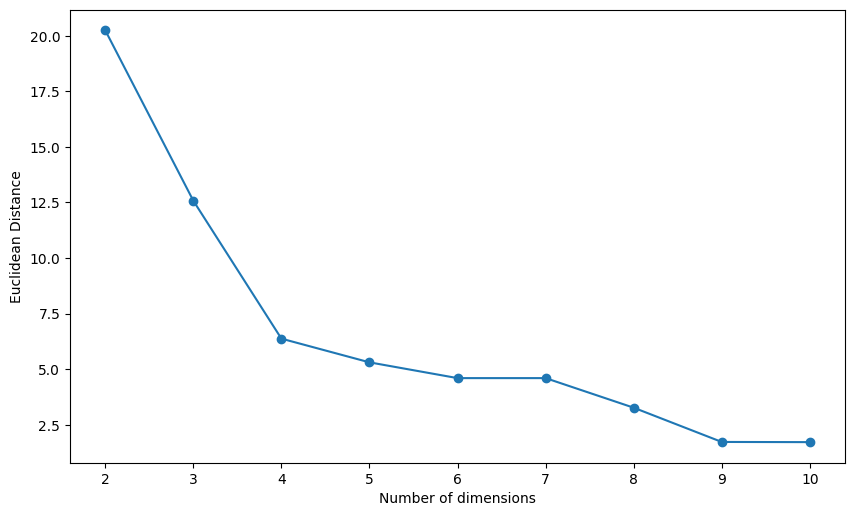

In [273]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(range(2,len(deltas)+2), deltas, 'o-')

plt.xlabel('Number of dimensions')
plt.ylabel('Euclidean Distance')
plt.show()

### 1.3 Optinal number of clusters
So far, we know that users can be classified into two groups.

However, there must be a number of cluster that is optimal for the dataset.
We can to find the optimal number of traveller groups, by using various of cluster validation techniques.
The elbow method is a widely used for calculate the optimal number of clusters.
For different values of $k$, we calculate the Within-Cluster-Sum of Squared (wss) Errors and chose the first $k$ values for which the error values start to diminish.

The implementation of the Within-Cluster-Sum of Squared (wss) Errors calculator for KMeans clustering algorithm is presented as the following scripts:


In [22]:
# Within-Cluster-Sum of Squared (wss) Errors 
def calculate_wss_kmeans(data, max_cluster):
    result = []
    for k in range(1, max_cluster+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        centroids = kmeans.cluster_centers_
        predicted_clusters = kmeans.predict(data)
        current_sse = 0

        for i in range(len(data)):
            current_center = centroids[predicted_clusters[i]]
            current_sse += (data.loc[i][0] - current_center[0])**2 + (data.loc[i][1] - current_center[1])**2

        result.append(current_sse)
    
    return result

In [27]:
wss_result = calculate_wss_kmeans(data, 50)

We obtain the folloing graph for WSS values of our dataset for different $k$ number of clusters.
The plot took shape of an arm, and we can chose the optimal at the elbow.
It is suggested that the optimal values $k$ can be chosen within the range [7, 10], as highlighted in the plot.

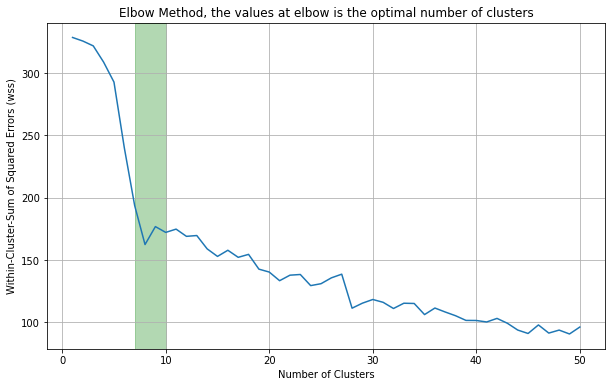

In [29]:
plt.figure(figsize=(10,6), dpi=100)
plt.grid()
plt.plot(range(1, len(wss_result)+1), wss_result)
plt.ylabel('Within-Cluster-Sum of Squared Errors (wss)')
plt.xlabel('Number of Clusters')
plt.title('Elbow Method, the values at elbow is the optimal number of clusters')

plt.axvspan(7, 10, color='green', alpha=0.3)
plt.show()

## Question 2
Implement two alternative solutions of [Q1](#question-1) (3). Compare and report the findings.

### Silhouette method with KMeans

Compare to the elbow method, the silhouette method measures the similarity of a point to it own cluster compared to the other clusters.
The silhouette score is calculated with the function `silhouette_score()` from sklearn library.

We aim to choose $k$ value for the highest silhouette score.

In [61]:
# Silhouette Method
def calculate_silhouette_kmeans(data, max_cluster):
    result = []
    for k in range(2, max_cluster+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        labels = kmeans.labels_
        
        result.append(silhouette_score(data, labels, metric='euclidean'))
    
    return result

In [13]:
silhouette_result = calculate_silhouette_kmeans(data, 50)

We obtain the folloing graph silhouette scores of KMeans clustering algorithm for our dataset with different $k$ number of clusters.

The result shows that $k=2$ clusteres would maximize the average silhouette score for the dataset (highlighted as red dot). 
Otherwise, we can chose the second peak, at $k = 8$ (highlighted as orange dot).

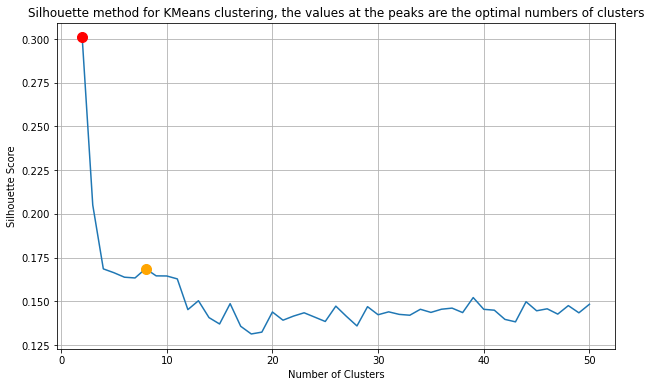

In [14]:
plt.figure(figsize=(10,6), dpi=100)
plt.grid()
plt.plot(range(2, len(silhouette_result) + 2),silhouette_result)
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')

plt.title('Silhouette method for KMeans clustering, the values at the peaks are the optimal numbers of clusters')

x = 2
y = silhouette_result[x-2]
plt.plot(x, y, 'o', color='red', markersize=10)

# plt.axvspan(6, 9, color='green', alpha=0.3)
plt.plot(8, silhouette_result[8-2], 'o', color='orange', markersize=10)

plt.show()

### Silhouette method with Spectral Clustering

Spectral Clustering is another clustering algorithm.
Compare to KMeans algorithm wich groups the data based on how close they are toward the cluster center (compactness approach), Spectral clustering algorithm use the connectivity approach, wich group the datapoint based on their $\epsilon$ distance to each other.

In [15]:
# Silhouette Method
def calculate_silhouette_SC(data, max_cluster):
    result = []
    for k in range(2, max_cluster+1):
        dbscan = SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
        dbscan.fit(data)
        
        labels = dbscan.labels_
        
        result.append(silhouette_score(data, labels, metric='euclidean'))
    
    return result

In [16]:
silhouette_SC_result = calculate_silhouette_SC(data, 50)

We obtain the folloing graph silhouette scores of Spectral clustering algorithm for our dataset with different $k$ number of clusters.

The result shows that $k=2$ clusteres would maximize the average silhouette score for the dataset (highlighted as red dot). 
Otherwise, we can chose the second peak, at $k = 5$ (highlighted as orange dot).

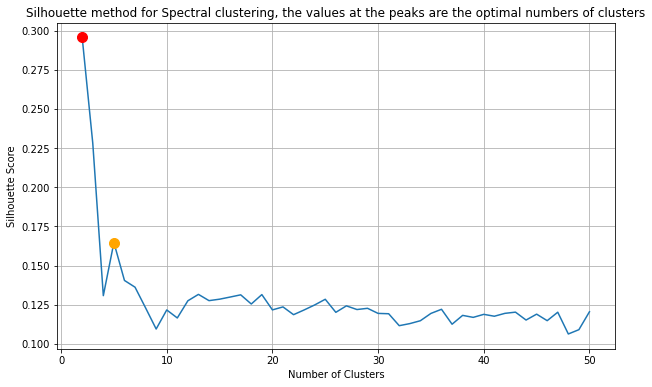

In [17]:
plt.figure(figsize=(10,6), dpi=100)
plt.grid()
plt.plot(range(2, len(silhouette_SC_result)+2), silhouette_SC_result)
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')

plt.title('Silhouette method for Spectral clustering, the values at the peaks are the optimal numbers of clusters')

x = 2
y = silhouette_SC_result[x-2]
plt.plot(x, y, 'ro', markersize=10)

plt.plot(5, silhouette_SC_result[5-2], 'o', color='orange', markersize=10)


plt.show()

## Question 3
Evaluate quality of the groupings that you have reported as a solution of [Q1](#question-1) (3) and [Q2](#question-2).
Based on the evaluation outcomes, report the best solution and explain the results.

In question 1 and 2, we have obtained results as the optimal number of clusters for the dataset based on different clustering algorithms and cluster evaluation techniques.
We summarize the findings as the table:

| Index | Clustering algirithm | Evaluation technique   | Optimal $k$   |
|-------|----------------------|------------------------|---------------|
| 1     | KMeans clustering    | Elbow WSSE             | [7, 10]       |
| 2     | KMeans clustering    | Silhouette Score       | 2, 8          |
| 3     | Spectral clustering  | Silhouette Score       | 2, 5          |

The first method (elbow) has zoned the optimal values within the range from 6 to 10 clusters.
However, in the second and third method, we can see that the optimal values are 2, 5, and 8.

The value $k=8$ is within the optimal range [7, 10] from the first method and thus having a reasonable Within-Cluster-Sum of Squared Errors value (marked as blue dot).
Onthe other hand, the values $k=2$ and $k=5$ will result in higher error values (marked as red dot).

In conclusion, the optimal number of cluster is $k=8$

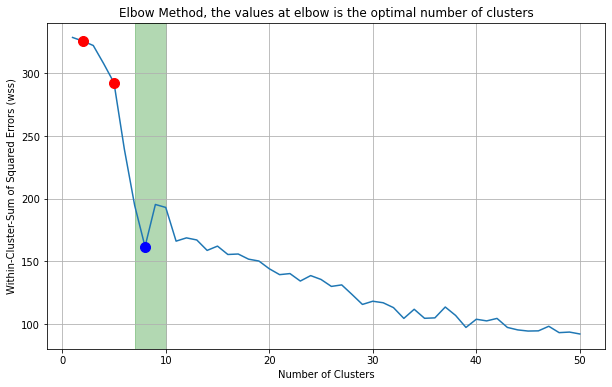

In [18]:
plt.figure(figsize=(10,6), dpi=100)
plt.grid()

plt.plot(range(1, len(wss_result)+1), wss_result, label='KMeans, Elbow')

plt.ylabel('Within-Cluster-Sum of Squared Errors (wss)')
plt.xlabel('Number of Clusters')
plt.title('Elbow Method, the values at elbow is the optimal number of clusters')

plt.axvspan(7, 10, color='green', alpha=0.3)

x = [2, 5, 8]
y = [wss_result[x - 1] for x in x]

for i in range(len(x)):
    col = 'red'
    if x[i] in range(7, 10):
        col = 'blue'
    
    plt.plot(x[i], y[i], 'o', color=col, markersize=10)

plt.show()

## Question 4
Quantify and print the relationship among independent variables of this dataset (tripadvisor_review.csv).
Calculate two collective variables that represent the same dataset. 
Create a two-dimensional plot to display the relationship between these new variables and explain the plot.

We use the correlation matrix to demonstrate the relationship between different features.
A heatmap is plotted to illustrate the correlation matrix

,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
Category 1,1.000000,-0.187692,0.008613,0.073456,-0.100483,0.094142,-0.012474,0.020029,-0.047313,0.050700
Category 2,-0.187692,1.000000,0.043586,0.131624,0.119631,0.148404,0.110052,-0.158642,0.073342,-0.065762
Category 3,0.008613,0.043586,1.000000,0.061128,0.281668,0.356435,0.750651,-0.172953,-0.085435,-0.440543
Category 4,0.073456,0.131624,0.061128,1.000000,0.101878,0.215866,0.228348,-0.103583,0.026670,-0.352909
Category 5,-0.100483,0.119631,0.281668,0.101878,1.000000,0.581306,0.232318,-0.020957,0.041693,-0.247470
Category 6,0.094142,0.148404,0.356435,0.215866,0.581306,1.000000,0.430743,0.000071,0.096410,-0.438104
Category 7,-0.012474,0.110052,0.750651,0.228348,0.232318,0.430743,1.000000,-0.072492,0.084965,-0.710731
Category 8,0.020029,-0.158642,-0.172953,-0.103583,-0.020957,0.000071,-0.072492,1.000000,0.169695,0.114701
Category 9,-0.047313,0.073342,-0.085435,0.026670,0.041693,0.096410,0.084965,0.169695,1.000000,-0.045682
Category 10,0.050700,-0.065762,-0.440543,-0.352909,-0.247470,-0.438104,-0.710731,0.114701,-0.045682,1.000000


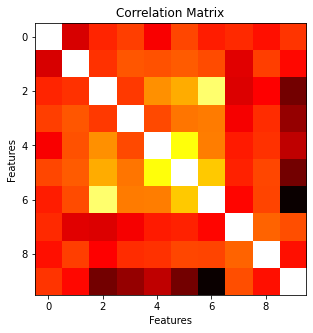

In [19]:
corr1 = data.corr()

display(corr1)

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(corr1, cmap='hot', interpolation='nearest')
plt.ylabel('Features')
plt.xlabel('Features')
plt.title('Correlation Matrix')
plt.show()

The given data of 10 features can be describe by 2 vectors using the Principal Component analysis procedure.
The relation between the two vectors can be described in a 2D plot.

Original data shape: (980, 10)
Reduced data shape: (980, 2)


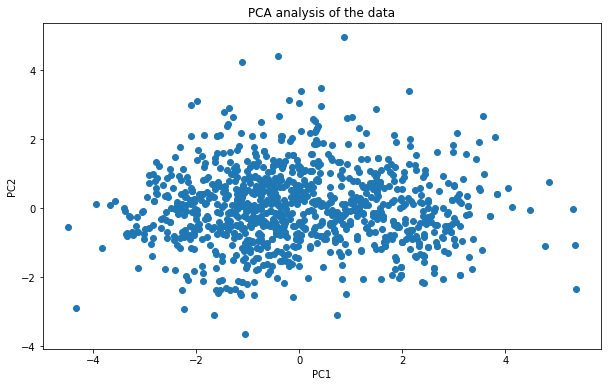

In [20]:
# Normalize the data
Xnorm = scale(data)

print(f'Original data shape: {data.shape}')

# Run PCA
pca = PCA(n_components=2)
Zred = pca.fit_transform(Xnorm)

print(f'Reduced data shape: {Zred.shape}')

# Plot the two vectors
plt.figure(figsize=(10,6), dpi=100)
plt.title('PCA analysis of the data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.plot(Zred[:,0], Zred[:,1], 'o')

## Question 5
Is there any loss of information due to the transformation performed in [Q4](#question-4)? Explain your answer with evidence.

In [23]:
# Perform data reconstruction
Xrex = pca.inverse_transform(Zred)
print(f'Reconstructed data shape: {Xrex.shape}')

# Measure the reconstruction error
rec_error = np.linalg.norm(Xnorm - Xrex) / np.linalg.norm(Xnorm)
print(f'Reconstruction error: {rec_error}')

Reconstructed data shape: (980, 10)
Reconstruction error: 0.7589269810329784


## Question 6
Principal component analysis applied on a given dataset, and the percentage of variance for the first $N$ components is $X\%$. 
How is this percentage of variance computed?

**Explained variance** is a measurement for how much variance can be attributed from the dataset to each of the principal components (also known as eigenvectors).
For example, a dataset with 10 dimension can be explained by two component, the first component can explain 20% of the variance, and the other component explain the rest of 80%.

We can calculate the explained variance by a function of ratio.
For a $n$ eigenvectors, the related eigenvalue $\lambda_i$ and the sum of all eigenvalues, we calculate the explained variance as following:

$$
\frac{\lambda_i}{\sum^n_{j=1}\lambda_j}
$$

## Question 7
Apply component factor and projection-based dimensionality reduction approaches on the given dataset (tripadvisor_review.csv) for creating three collective variables. 
Does this new feature space improve the grouping of travellers compared to original dataset? 
Present your results with appropriate evidences.

In [43]:
Xnorm = scale(data)
pca = PCA(n_components=3)
pca_Zred = pd.DataFrame(pca.fit_transform(Xnorm))

isomap = Isomap(n_components=3)
isomap_Zred = pd.DataFrame(isomap.fit_transform(Xnorm))

original_data_norm = pd.DataFrame(Xnorm)

print(f'Reduced data shape: {isomap_Zred.shape}')

Reduced data shape: (980, 3)


In [44]:
# Elbow method
wss_pca = calculate_wss_kmeans(pca_Zred, 50)
wss_isomap = calculate_wss_kmeans(isomap_Zred, 50)
wss_original = calculate_wss_kmeans(original_data_norm, 50)

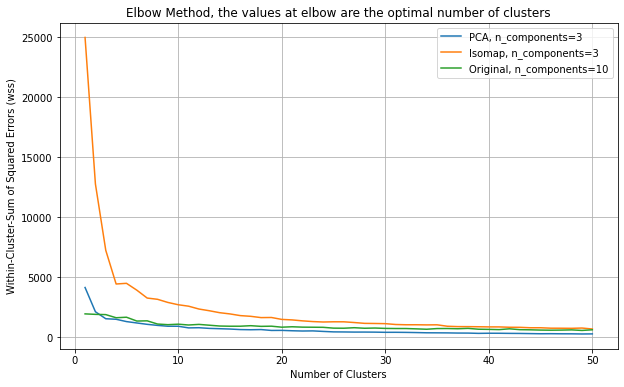

In [66]:
plt.figure(figsize=(10,6), dpi=100)
plt.grid()
plt.plot(range(1, len(wss_pca)+1), wss_pca, label='PCA, n_components=3')
plt.plot(range(1, len(wss_isomap)+1), wss_isomap, label='Isomap, n_components=3')
plt.plot(range(1, len(wss_original)+1), wss_original, label='Original, n_components=10')

plt.ylabel('Within-Cluster-Sum of Squared Errors (wss)')
plt.xlabel('Number of Clusters')
plt.title('Elbow Method, the values at elbow are the optimal number of clusters')

plt.legend(loc='best')
plt.show()

In [62]:
sil_pca = calculate_silhouette_kmeans(pca_Zred, 50)
sil_isomap = calculate_silhouette_kmeans(isomap_Zred, 50)
sil_original = calculate_silhouette_kmeans(original_data_norm, 50)

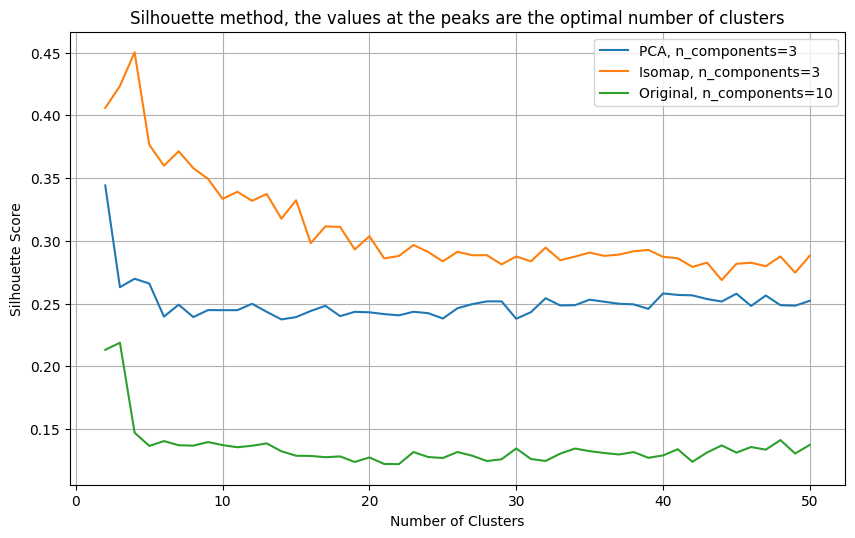

In [168]:
plt.figure(figsize=(10,6), dpi=100)
plt.grid()

plt.plot(range(2, len(sil_pca)+2), sil_pca, label='PCA, n_components=3')
plt.plot(range(2, len(sil_isomap)+2), sil_isomap, label='Isomap, n_components=3')
plt.plot(range(2, len(sil_original)+2), sil_original, label='Original, n_components=10')

plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.title('Silhouette method, the values at the peaks are the optimal number of clusters')

# plt.vlines(3, 0, 25000, color='red', linestyles='dashed', label='clusters=3')

plt.legend(loc='best')
plt.show()

## Question 8
Let’s consider the data shown in the figure below.
1. Is it possible to obtain the cluster shown in the figure by k-means clustering (k = 6)? 
Provide evidence including code and explanation to justify your findings.
2. Explore state-of-the-art clustering methods (explore recent research articles) that can produce better results than k-means for this problem? 
Describe the selected approach, evaluate performance and report your findings

![Scatter plot with expected clusters (elliptical shapes)](./scatter_plot.png)

In [118]:
## Reproduce the plot from the lecture

feature_2 = np.concatenate(
    (
        np.ones(shape = 8),
        np.linspace(2, 7, num = 6),
        np.linspace(3, 5, num = 3),
        np.linspace(2, 6, num = 5),
        np.ones(4) * 10,
        np.ones(3) * 12
    ), 
    axis = None
)

feature_1 = np.concatenate(
    (
        np.linspace(25, 55, num = 8),
        np.linspace(59, 79, num = 6),
        np.linspace(20, 40, num = 3),
        np.linspace(5, 10, num = 5),
        np.linspace(45, 60, num = 4),
        np.linspace(65, 75, num = 3)
    ), 
    axis = None
)

data_q8 = pd.DataFrame({'Feature-1': feature_1, 'Feature-2': feature_2})

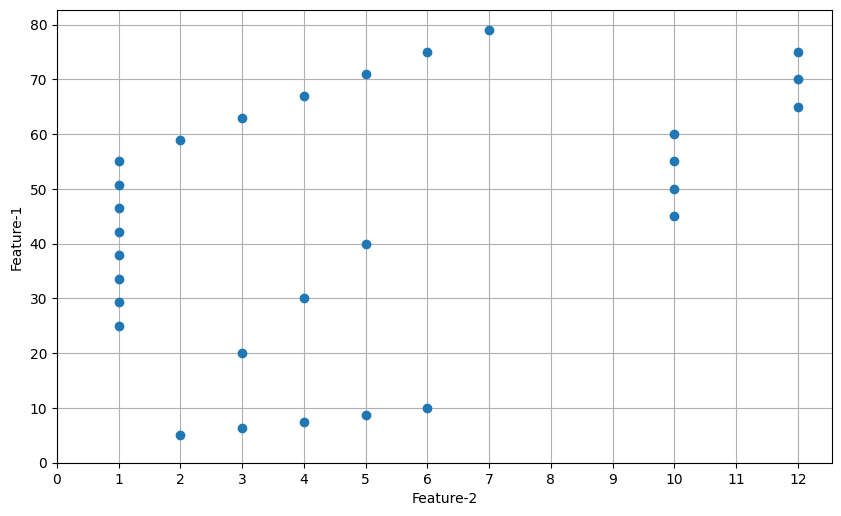

In [167]:
plt.figure(figsize=(10,6), dpi=100)
plt.grid()
plt.plot(data_q8['Feature-2'], data_q8['Feature-1'], 'o')
plt.xlabel('Feature-2')
plt.xticks(np.arange(0, 13, 1))
plt.ylabel('Feature-1')
plt.yticks(np.arange(0, 90, 10))
plt.show()

### Kmeans Clustering n=6

In [122]:
data_q8_norm = pd.DataFrame(scale(data_q8))

In [123]:
kmeans_q8 = KMeans(n_clusters=6)
kmeans_q8.fit(data_q8_norm)
labels_q8 = kmeans_q8.labels_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


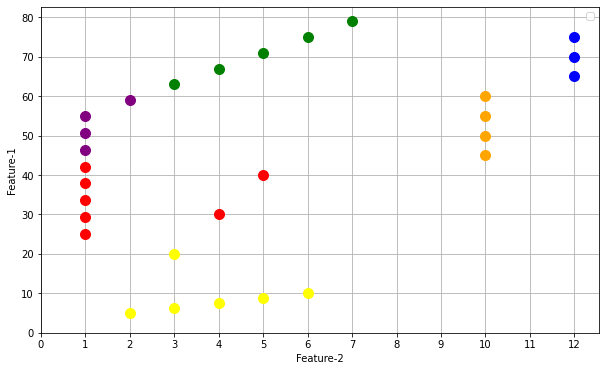

In [124]:
plt.figure(figsize=(10,6), dpi=100)
plt.grid()
for i in range(len(data_q8)):
    col = 'red'
    if labels_q8[i] == 1:
        col = 'blue'
    elif labels_q8[i] == 2:
        col = 'green'
    elif labels_q8[i] == 3:
        col = 'yellow'
    elif labels_q8[i] == 4:
        col = 'purple'
    elif labels_q8[i] == 5:
        col = 'orange'
    
    plt.plot(data_q8['Feature-2'][i], data_q8['Feature-1'][i], 'o', color=col, markersize=10)

plt.xlabel('Feature-2')
plt.xticks(np.arange(0, 13, 1))
plt.ylabel('Feature-1')
plt.yticks(np.arange(0, 90, 10))

plt.legend(loc='best')
plt.show()

### Gaussian Mixture

In [160]:
gaussian = GaussianMixture(n_components=6, covariance_type='diag')
data_q8['label'] = gaussian.fit_predict(data_q8_norm)

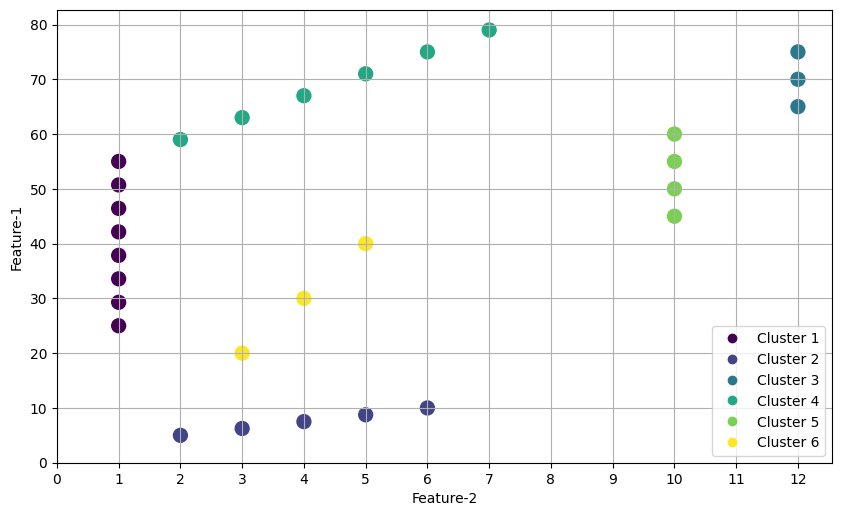

In [274]:
plt.figure(figsize=(10,6), dpi=100)
plt.grid()

scatter = plt.scatter(
    data_q8['Feature-2'], 
    data_q8['Feature-1'], 
    c=data_q8['label'], 
    s=100
)

plt.xlabel('Feature-2')
plt.xticks(np.arange(0, 13, 1))
plt.ylabel('Feature-1')
plt.yticks(np.arange(0, 90, 10))

plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=[f'Cluster {i}' for i in range(1,7)],  
    loc='lower right'
)

plt.show()